In [24]:
# Imports:
import numpy as np
import healpy as hp
import os
import time
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import pylab as plt
import healsparse

In [25]:


########################### Mass Maps ################################
#path_in = '/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150_2/shells_z27_subsampleauto_groupiso/'
nshells = 27
seed = 0
IC='150_2'     #IC=150,195, 150_2

path_in = '/global/cfs/cdirs/lsst/groups/WL/projects/hos-tt/sims/L845/HACC'+IC+'/shells_z'+str(nshells)+'_subsampleauto_groupiso/'
directory_contents = os.listdir(path_in)
print("*** original mass sheets ***")
print(directory_contents)

path_out_tidal = '../../../HACC-Y1/tidalfield/'
directory_contents = os.listdir(path_out_tidal)
print("*** tidal fields ***")
print(directory_contents)

#---
tmpfile = np.load("/global/cfs/cdirs/lsst/groups/WL/projects/hos-tt/sims/L845/HACC150_2/shells_z"+str(nshells)+"_subsampleauto_groupiso/shell_hacc_seed0_shell_info.npy")
zfile = np.zeros([nshells,5])
for i in np.arange(nshells):
    #print(tmpfile[i][0], tmpfile[i][1], tmpfile[i][2], tmpfile[i][3], tmpfile[i][4])
    zfile[i,0:5]= [tmpfile[i][0], tmpfile[i][1], tmpfile[i][2], tmpfile[i][3], tmpfile[i][4]]
snaplist = zfile[:,0].astype(int)
zlist=zfile[:,1]
#---

H0 = 71.0
Om0=0.2648
Ob0=0.044792699861138666
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Ob0=Ob0)


#include a 0.1Mpc/h smoothing of the tidal field, expressed here in Mpc (not Mpc/h):
#smoothing_comoving = 0.1/cosmo.h*u.Mpc
smoothing_comoving = 0.1/cosmo.h*u.Mpc
print("smoothing the field with", smoothing_comoving, " (e.g. not Mpc/h)")

n_slices = np.size(zlist)


*** original mass sheets ***
['shell_hacc_seed1_nside4096_haloes_imap7.fits', 'shell_hacc_seed0_nside4096_haloes_imap0.fits', 'shell_hacc_seed0_nside4096_imap24.fits', 'shell_hacc_seed2_nside4096_imap15.fits', 'shell_hacc_seed0_nside4096_imap6.fits', 'shell_hacc_seed2_nside4096_imap20.fits', 'shell_hacc_seed2_nside4096_haloes_imap5.fits', 'shell_hacc_seed1_nside4096_haloes_imap9.fits', 'shell_hacc_seed0_nside4096_imap12.fits', 'shell_hacc_seed1_nside4096_alms_imap6.fits', 'shell_hacc_seed1_nside4096_alms_imap21.fits', 'shell_hacc_seed2_nside4096_imap0.fits', 'shell_hacc_seed1_nside4096_imap21.fits', 'shell_hacc_seed1_nside4096_alms_imap2.fits', 'shell_hacc_seed0_nside4096_haloes_imap6.fits', 'shell_hacc_seed0_nside4096_alms_imap7.fits', 'shell_hacc_seed2_nside4096_haloes_imap16.fits', 'shell_hacc_seed0_nside4096_haloes_imap26.fits', 'shell_hacc_seed2_nside4096_imap22.fits', 'shell_hacc_seed2_nside4096_haloes_imap0.fits', 'shell_hacc_seed1_nside4096_imap15.fits', 'shell_hacc_seed1_nside

In [26]:
def compute_tidal_tensor_spherical_new(hpmap, smoothing):

    #-----------------------
    # Get alm from delta map:
    print("starting delta map2alm")
    #The input maps must all be in ring ordering.
    
    delta=np.copy(hpmap)
    
    alm_E = hp.sphtfunc.map2alm(hpmap, lmax=5000, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)
    alm_B = alm_E*0.0;
    print("Done forward transform")
    
    if (smoothing > 0.0) :
        #smooth by sigma, given in radians
        print("smoothing by beam with sigma = "+str(smoothing)+"rad")
        alm_E_smooth=hp.sphtfunc.smoothalm(alm_E, fwhm=0.0, sigma=smoothing, beam_window=None, pol=False, mmax=None, verbose=True, inplace=True)
        alm_E = alm_E_smooth
        del alm_E_smooth
        print("Done Smoothing")
      
    print("Starting shear alm2map")
    nside=hp.get_nside(hpmap)
    start = time.time()
    maps_QU = hp.alm2map_spin((alm_E, alm_B), nside, spin=2,lmax=5000,mmax=None)
    
    print("Got QU maps")
    end = time.time()
    print(end - start)

    # In 2D cartesian, s11(k)+s22(k)=delta(k)
    # In the spherical polarization framework, we have:
    # Q is 'g1' = (t11 - t22)
    # delta is t11 + t22
    # U is 'g2' = t12
    # t11 is (Q +delta)/2
    # t22 is (delta-Q)/2
    # Need to subtract off the trace, affecting s_11 and s_22...
    
    tidal_tensor_sph = np.zeros((hp.nside2npix(nside),3),dtype=np.float32)

    #t11 
    tidal_tensor_sph[:,0] = (maps_QU[0]+delta)/2.0 - 1./3 * hpmap
    
    #t22
    tidal_tensor_sph[:,1] = (delta-maps_QU[0])/2.0 - 1./3 * hpmap
 
    #t12
    tidal_tensor_sph[:,2] = maps_QU[1]

    print("Done!")         
    
    return tidal_tensor_sph    


In [27]:
def MakeFullSky(binmap,Nside):


    # Format is nested, order into ring in order to use alm2maps transforms
    # and degrade NSIDE 
    #print("NSIDE_orig=", hp.get_nside(tmp))
    #binmap=hp.pixelfunc.ud_grade(tmp, 4096, pess=False, order_in='NESTED', order_out='RING', power=None, dtype=None)
    #print("NSIDE_new=", hp.get_nside(binmap))

    # Or reorder, keeping all full NSIDE resolution
    #binmap = hp.reorder(tmp, n2r = True)
    #del tmp
    
    print("Got RING-ordered input map")
    
    # Replicate the Octant:
    # Note that the rotator interpolate in pixel space, which can create visible differences for sparsely sampled maps.
    # In the end, only the original octant is selected, so this has a negligible effect, except perhaps some boundary residuals.
    # We do neglect those here.
    
   # Load mask for octant, and find unmasked pixel IDs
    if(Nside==4096):
        mask = np.load('mask_allsky.npy')
    else:
        print('No mask provided, stopping here')
        stop
    
    #hp.mollview(mask, nest=False)
    #plt.show()
    npix = hp.nside2npix(Nside)
    pix_array = np.arange(npix)
    pixel_id = pix_array[mask>0]
    
    # Find angle for these unmasked pixels, rotate them 7 times to populate the full sky, then extract the new pixel IDs
    # These rotations avoid reflections, which can cause additional clustering

    theta, phi = hp.pix2ang(Nside, pixel_id, nest=False, lonlat=False)


    pixel_id2 = hp.ang2pix(Nside, theta, phi+np.pi/2, nest=False, lonlat=False)
    pixel_id3 = hp.ang2pix(Nside, theta, phi+np.pi, nest=False, lonlat=False)
    pixel_id4 = hp.ang2pix(Nside, theta, phi+3*np.pi/2, nest=False, lonlat=False)
    pixel_id5 = hp.ang2pix(Nside, np.pi-theta, -phi, nest=False, lonlat=False)
    pixel_id6 = hp.ang2pix(Nside, np.pi-theta, -phi+np.pi/2, nest=False, lonlat=False)
    pixel_id7 = hp.ang2pix(Nside, np.pi-theta, -phi+np.pi, nest=False, lonlat=False)
    pixel_id8 = hp.ang2pix(Nside, np.pi-theta, -phi+3*np.pi/2, nest=False, lonlat=False)
    
    # Assign the original octant pixel values to the other 7 octant using the relation found above 

    binmap[pixel_id2]= binmap[pixel_id]
    binmap[pixel_id3]= binmap[pixel_id]
    binmap[pixel_id4]= binmap[pixel_id]
    binmap[pixel_id5]= binmap[pixel_id]
    binmap[pixel_id6]= binmap[pixel_id]
    binmap[pixel_id7]= binmap[pixel_id]
    binmap[pixel_id8]= binmap[pixel_id]

    return binmap

Working on file /global/cfs/cdirs/lsst/groups/WL/projects/hos-tt/sims/L845/HACC150_2/shells_z27_subsampleauto_groupiso/shell_hacc_seed0_nside4096_imap1.fits


/tmp/ipykernel_1304060/1130229418.py:17: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(binmap), nest=False)


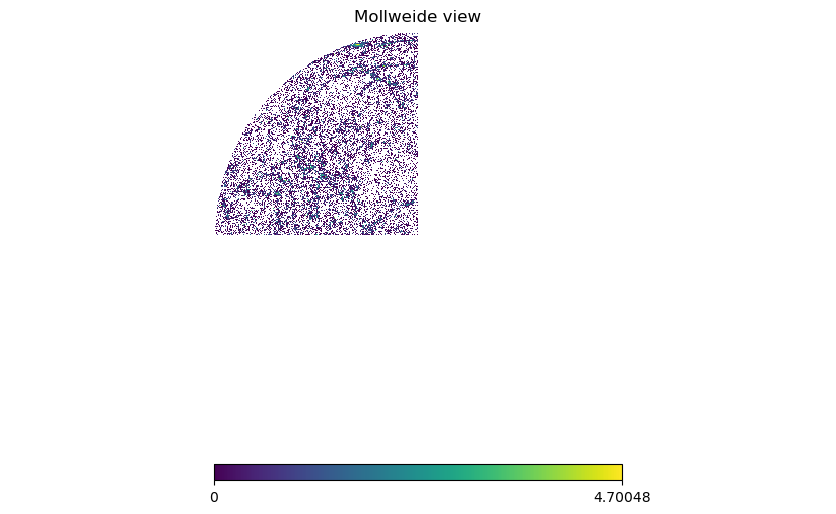

Got RING-ordered input map


/tmp/ipykernel_1304060/1130229418.py:23: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(binmap), nest=False)


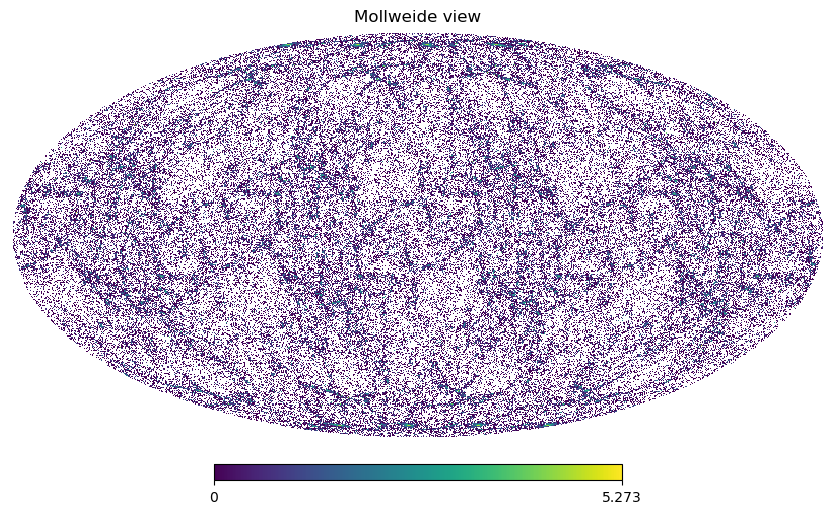

over density: -1.0 1050.7942 -3.326757e-06


/tmp/ipykernel_1304060/1130229418.py:36: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(binmap), cbar=True, lonra=lonra, latra=latra,


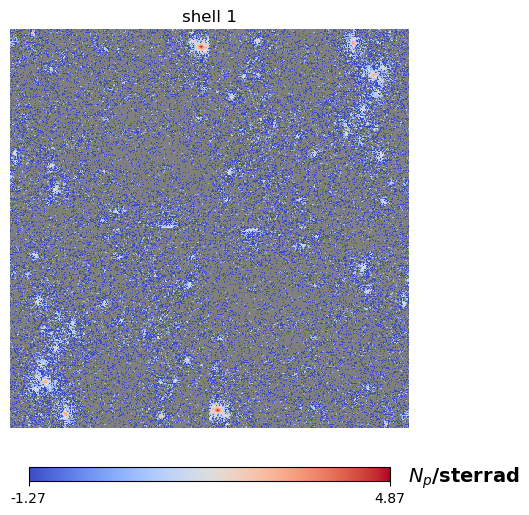

smoothing= 0.0014971187156797073  rad, = 5.146715030309609  arcmin
starting delta map2alm
Done forward transform
smoothing by beam with sigma = 0.0014971187156797073rad
Done Smoothing
Starting shear alm2map


/tmp/ipykernel_1304060/1680471417.py:17: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  alm_E_smooth=hp.sphtfunc.smoothalm(alm_E, fwhm=0.0, sigma=smoothing, beam_window=None, pol=False, mmax=None, verbose=True, inplace=True)


Got QU maps
65.86504673957825
Done!
Applied mask
s11: -21.943314 204.23196 -0.008381116
s22: -29.495628 146.03275 0.008368239
s12: -60.28254 84.44243 -1.0423472e-06


/tmp/ipykernel_1304060/1130229418.py:102: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(s[:,0]), nest=False)
/tmp/ipykernel_1304060/1130229418.py:102: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(s[:,0]), nest=False)


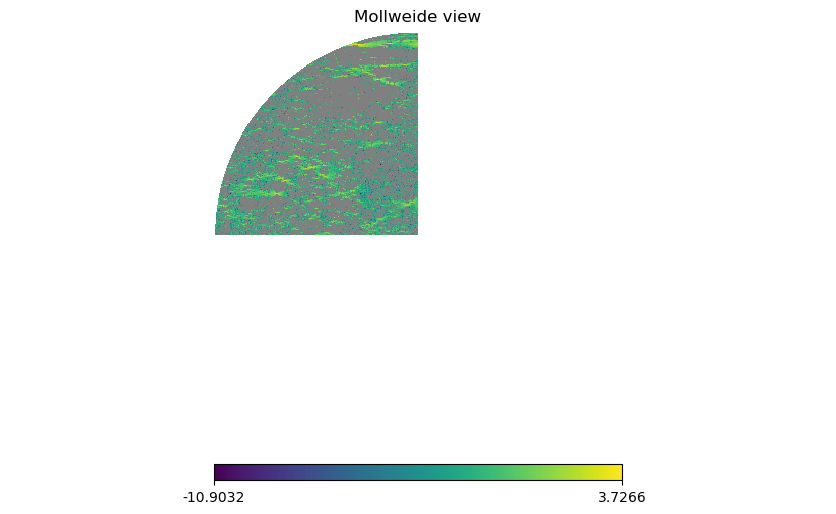

/tmp/ipykernel_1304060/1130229418.py:106: RuntimeWarning: divide by zero encountered in log
  hp.cartview(np.log(s[:,0]), cbar=True, lonra=lonra, latra=latra,
/tmp/ipykernel_1304060/1130229418.py:106: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(s[:,0]), cbar=True, lonra=lonra, latra=latra,
/tmp/ipykernel_1304060/1130229418.py:115: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(s[:,1]), nest=False)
/tmp/ipykernel_1304060/1130229418.py:115: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(s[:,1]), nest=False)


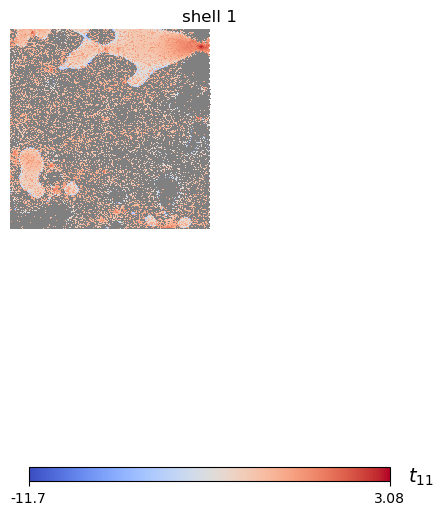

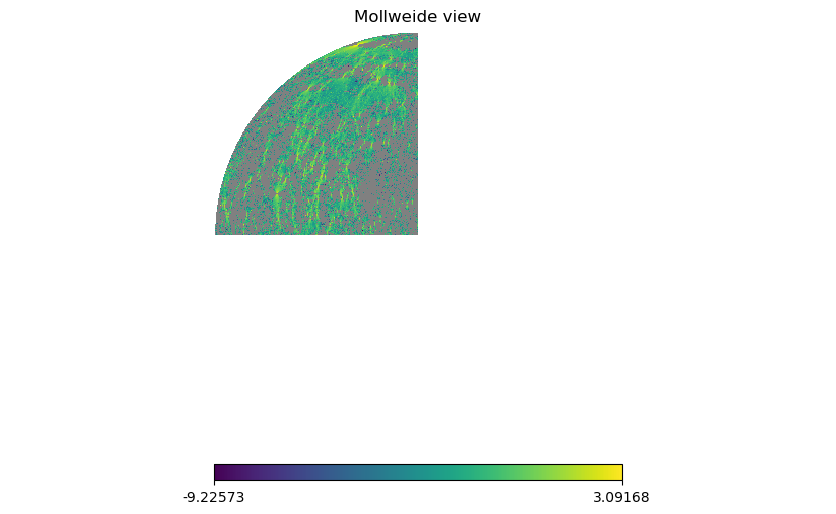

/tmp/ipykernel_1304060/1130229418.py:119: RuntimeWarning: divide by zero encountered in log
  hp.cartview(np.log(s[:,1]), cbar=True, lonra=lonra, latra=latra,
/tmp/ipykernel_1304060/1130229418.py:119: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(s[:,1]), cbar=True, lonra=lonra, latra=latra,


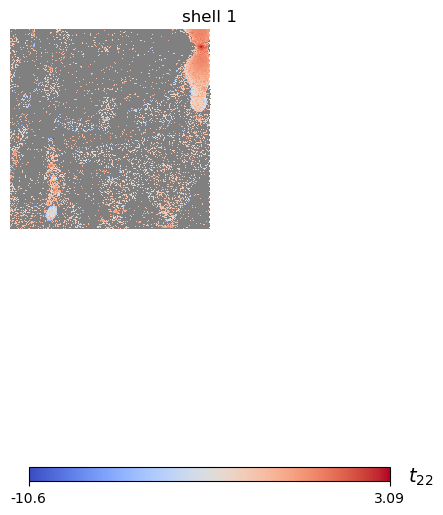

/tmp/ipykernel_1304060/1130229418.py:129: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(s[:,2]), nest=False)
/tmp/ipykernel_1304060/1130229418.py:129: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(s[:,2]), nest=False)


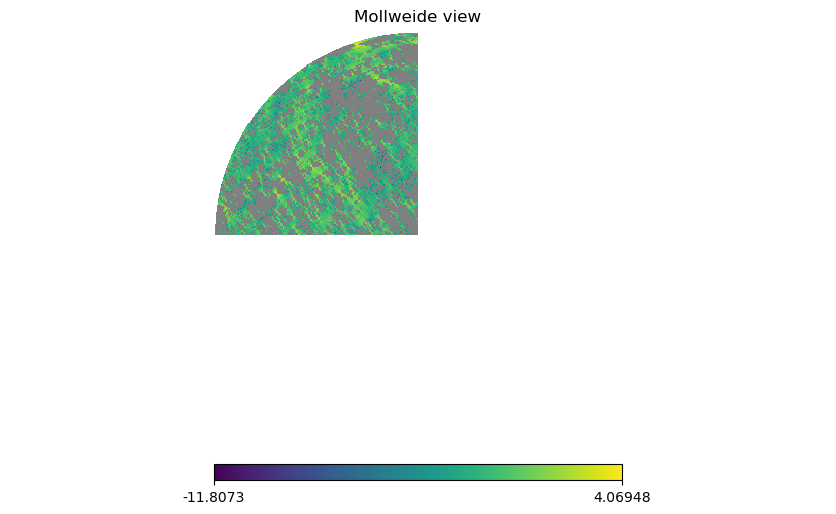

/tmp/ipykernel_1304060/1130229418.py:134: RuntimeWarning: divide by zero encountered in log
  hp.cartview(np.log(s[:,2]), cbar=True, lonra=lonra, latra=latra,
/tmp/ipykernel_1304060/1130229418.py:134: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(s[:,2]), cbar=True, lonra=lonra, latra=latra,


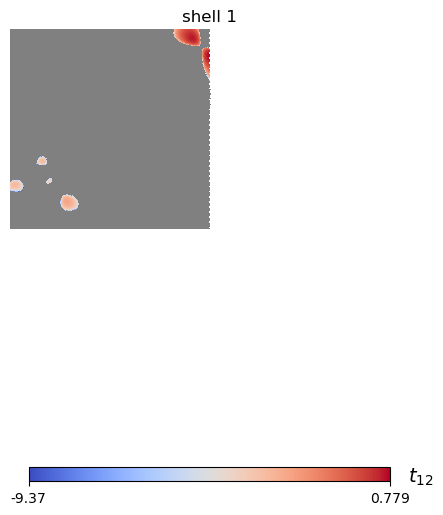

Saved s


In [28]:


# Load density maps from file, make them full sky, compute tidal tensor, save
# Repeat for all redshifts

for snap in range(1,2):

    # Load mass sheet. 
    data_file = path_in+'shell_hacc_seed'+str(seed)+'_nside'+str(Nside)+'_imap'+str(snap)+'.fits' 
    print('Working on file '+data_file)
    nside_c = 32    
    a = healsparse.HealSparseMap.read(os.path.join(path_in, data_file))
    binmap = a.generate_healpix_map()
    
    # turn masked pixels to zero.
    binmap[binmap<-1.0e+30]=0

    # Visualize:
    hp.mollview(np.log(binmap), nest=False)
    plt.show()

    binmap = MakeFullSky(binmap,Nside)
    
    # Visualize:
    hp.mollview(np.log(binmap), nest=False)
    plt.show()


    # Normalize the maps correctly:       
    mean_rho = (np.mean(binmap)) # no factor of 8.0 since we have full sky data here
    binmap /= mean_rho 
    binmap -= 1
    print("over density:",np.min(binmap), np.max(binmap), np.mean(binmap))


    lonra = [-3, 3]
    latra = [-3, 3]
    hp.cartview(np.log(binmap), cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title="shell "+str(snap),
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$N_{p}$/sterrad')
    plt.show()
    
    # convert smoothing scale to anguar scales:
    shell_distance = cosmo.comoving_distance(zlist[snap]) #expressed here in Mpc as well (not Mpc/h):

    smoothing_angular = smoothing_comoving/shell_distance
    print("smoothing=", smoothing_angular, " rad, =", smoothing_angular*180/np.pi*60, " arcmin")

    s = compute_tidal_tensor_spherical_new(binmap,smoothing=smoothing_angular)

    #Apply mask to select just the octant.
    if(Nside==4096):
        fname = 'mask_allsky.npy'
    else:
        print('Must supply mask for your Nside')
        
    octant_mask= np.load(fname)
    
    s[:,0] *= octant_mask
    s[:,1] *= octant_mask
    s[:,2] *= octant_mask

    print("Applied mask")

    print("s11:",np.min(s[:,0]), np.max(s[:,0]), np.mean(s[:,0]))
    print("s22:",np.min(s[:,1]), np.max(s[:,1]), np.mean(s[:,1]))
    print("s12:",np.min(s[:,2]), np.max(s[:,2]), np.mean(s[:,2]))
    
    # Visualize:
    lonra = [-3, 3]
    latra = [-3, 3]

    #hp.mollview(np.log(s11), nest=False)
    hp.mollview(np.log(s[:,0]), nest=False)
    plt.show()


    hp.cartview(np.log(s[:,0]), cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title="shell "+str(snap),
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$t_{11}$')


    hp.mollview(np.log(s[:,1]), nest=False)
    plt.show()

    hp.cartview(np.log(s[:,1]), cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title="shell "+str(snap),
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$t_{22}$')
    plt.show()


    hp.mollview(np.log(s[:,2]), nest=False)
    plt.show()


    hp.cartview(np.log(s[:,2]), cbar=True, lonra=lonra, latra=latra,
            nest=False,
                title="shell "+str(snap),
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$t_{12}$')
    plt.show()

    fname = path_out_tidal+'tidal_field_map_'+str(snaplist[snap])+'_allsky_smooth_01Mpc.npy'
    np.save(fname,s)

    print("Saved s")

In [18]:
snaplist

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 2, 3])

In [19]:
zfile

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.10663984e-02,
        4.99000000e+02],
       [1.00000000e+00, 2.23804680e-02, 1.10663984e-02, 3.50154480e-02,
        4.88000000e+02],
       [2.00000000e+00, 4.79666319e-02, 3.50154480e-02, 6.01265823e-02,
        4.76000000e+02],
       [3.00000000e+00, 7.25720384e-02, 6.01265823e-02, 8.64864865e-02,
        4.65000000e+02],
       [4.00000000e+00, 1.00766703e-01, 8.64864865e-02, 1.15427303e-01,
        4.53000000e+02],
       [5.00000000e+00, 1.30483690e-01, 1.15427303e-01, 1.45952109e-01,
        4.41000000e+02],
       [6.00000000e+00, 1.61849711e-01, 1.45952109e-01, 1.79577465e-01,
        4.29000000e+02],
       [7.00000000e+00, 1.97854589e-01, 1.79577465e-01, 2.16707022e-01,
        4.16000000e+02],
       [8.00000000e+00, 2.36162362e-01, 2.16707022e-01, 2.57822278e-01,
        4.03000000e+02],
       [9.00000000e+00, 2.80254777e-01, 2.57822278e-01, 3.05194805e-01,
        3.89000000e+02],
       [1.00000000e+01, 3.3112

In [22]:
zlist

array([0.        , 0.02238047, 0.04796663, 0.07257204, 0.1007667 ,
       0.13048369, 0.16184971, 0.19785459, 0.23616236, 0.28025478,
       0.33112583, 0.3862069 , 0.44604317, 0.5112782 , 0.58267717,
       0.65024631, 0.7238422 , 0.79785331, 0.88555347, 0.97445972,
       1.07216495, 1.19912473, 1.34265734, 1.55725191, 1.93002915,
       2.52631579, 3.63133641])